 # Title (Current Word Count 526)
 
 
 #### By Chris Jung, Grace Wang,Haonan Su
 
 ## Background and Motivation
***Heart disease*** is the leading cause of death for men, women, and people of most racial and ethnic groups in most of the countries in the world, even in the countries with developed medical technology such as the United States. About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths.[[1]](https://www.who.int/health-topics/cardiovascular-diseases).
The US CDC(Centers for Disease Control and Prevention) suggests maintaining low blood pressure and cholesterol to lower the risk of heart disease [[2]](https://www.cdc.gov/heartdisease/prevention.htm).
For these reasons, we would like to raise awareness of heart disease and its prevention by analyzing the effect of maintaining low blood pressure and cholesterol on heart disease.

## Project Goal
- We are going to use actual medical records from the Cleveland Clinic Foundation to make a sampling distribution using bootstrapping sampling.
- Finally, we will conduct hypotheses tests to determine if the rate of heart disease is dependent on those two factors.
- By doing these activities, we hope to answer this question:

##### Do people with low blood pressure/cholesterol level have lower chance of developing heart disease?


## Data
- The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
- Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease.
- The response variable is the attribute "Class" which represents the presence of heart disease in 5 different categories.
- The explanatory variables are the attribute "trestpbs"(blood pressure), and "chol"(cholesterol).
- The detailed descriptions of the response variable and the two explanatory variables are:
    1. *class*: presence of heart disease. integer valued from 0 (no presence) to 4
    2. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    3. chol: serum cholestoral in mg/dl
    

In [1]:
#loads the libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
source("tests_tutorial_04.R")

#sets the seed for random events such as splitting the data
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests_tutorial_04.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Reading and Wrangling the Data

In [2]:
#reads in the data table with the 14 attributes
heart_data_0 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13))

#outputs the first 6 rows of the data frame
head(heart_data_0)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


As these columns are separated by commas, we use `read_csv` to read the file from the web. As well, we notice that columns X12 and X13 are treated as characters, not numbers, so we use the `as.numeric` function to change the data type.

In [17]:
#renames the columns
colnames(heart_data_0) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 2 attributes that will be used as well as the class
heart_data_1 <- heart_data_0%>%
select(trestbps, chol,  Class)
quantile(heart_data_1$trestbps)
quantile(heart_data_1$chol)
#We identify patients with trestbps data higher than 130(50th percentile) as having high resting blood pressure and indicate 
#this result with "HIGH" (and vice versa with "NORMAL"), 
#while changing the data type from numeric to factor


#########Due to the unknown problem 94 cannot be assigned to the correct category, 
#########here we discard the two data for trestbps = 94
heart_data_2 <- heart_data_1 %>% 
mutate(trestbps = replace(trestbps, trestbps >= 130, "HIGH"),
      trestbps = replace(trestbps, trestbps < 130, "LOW"))%>%
filter(trestbps != 94)

#We identify patients with chol data higher than 241(50th percentile) as having high serum cholestoral and indicate 
#this result with "HIGH" (and vice versa with "NORMAL"), 
#while changing the data type from numeric to factor

heart_data_3 <- heart_data_2 %>%
mutate(chol = replace(chol, chol > 241, "HIGH"),
      chol = replace(chol, chol <= 241, "LOW"))

#We identified patients with class data higher than 0 as having heart disease and indicated this result 
#with "YES" (and vice versa with "NO"). Also change the data type from number to factor
heart_data <- heart_data_3 %>%
mutate(Class = replace(Class, Class > 0, "YES"),
      Class = replace(Class, Class <= 0, "NO"))


#Split heart_data into two data frames
heart_data_trestbps <- heart_data%>%
select("trestbps","Class")

heart_data_chol <- heart_data%>%
select("chol","Class")
#outputs the first 6 rows of the data frame and heart_data is the data frame we will eventually use
head(heart_data)
head(heart_data_trestbps)
head(heart_data_chol)

0%  25%  50%  75% 100% 
  94  120  130  140  200

0%  25%  50%  75% 100% 
 126  211  241  275  564

trestbps,chol,Class
<chr>,<chr>,<chr>
HIGH,LOW,NO
HIGH,HIGH,YES
LOW,LOW,YES
HIGH,HIGH,NO
HIGH,LOW,NO
LOW,LOW,NO


trestbps,Class
<chr>,<chr>
HIGH,NO
HIGH,YES
LOW,YES
HIGH,NO
HIGH,NO
LOW,NO


chol,Class
<chr>,<chr>
LOW,NO
HIGH,YES
LOW,YES
HIGH,NO
LOW,NO
LOW,NO


Through the process above, we have converted the data frame into the format we need, which includes all the 
information in the data box about whether the patient has high resting blood pressure or not, whether 
the patient has high cholesterol or not and whether the patient has heart disease or not.

## Visualizing the Data

In the first diagram, We use whether the patient has high resting blood pressure as the X-axis variable, and mark whether the patient has heart disease with red and blue, red means the patient does not have high blood pressure, and vice versa.In the second diagram, We use whether the patient has high serum cholestoral as the X-axis variable, and mark whether the patient has heart disease with red and blue.

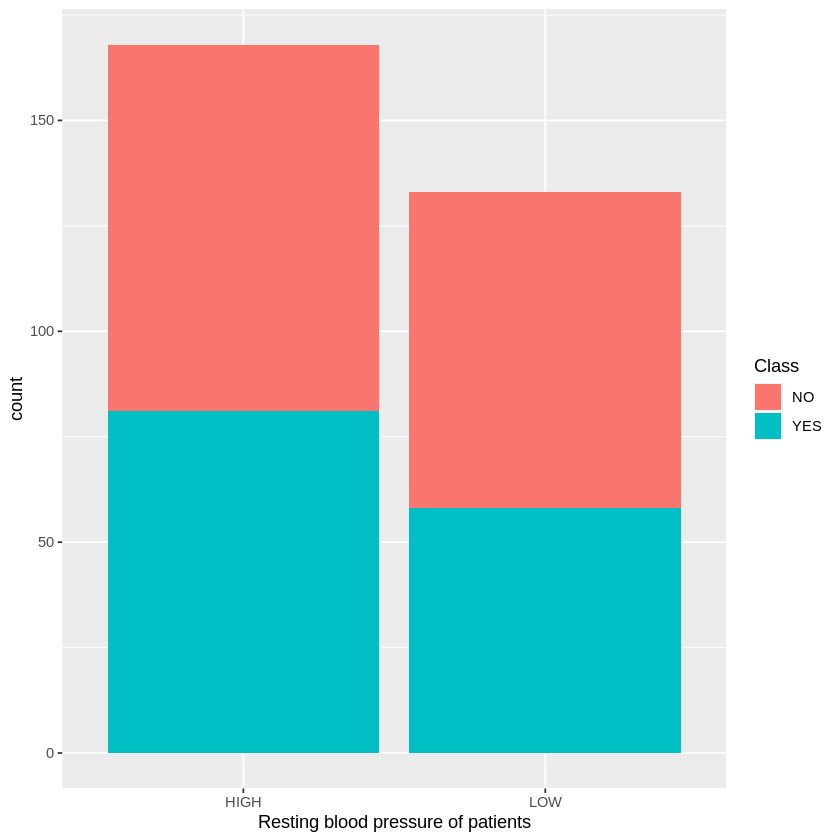

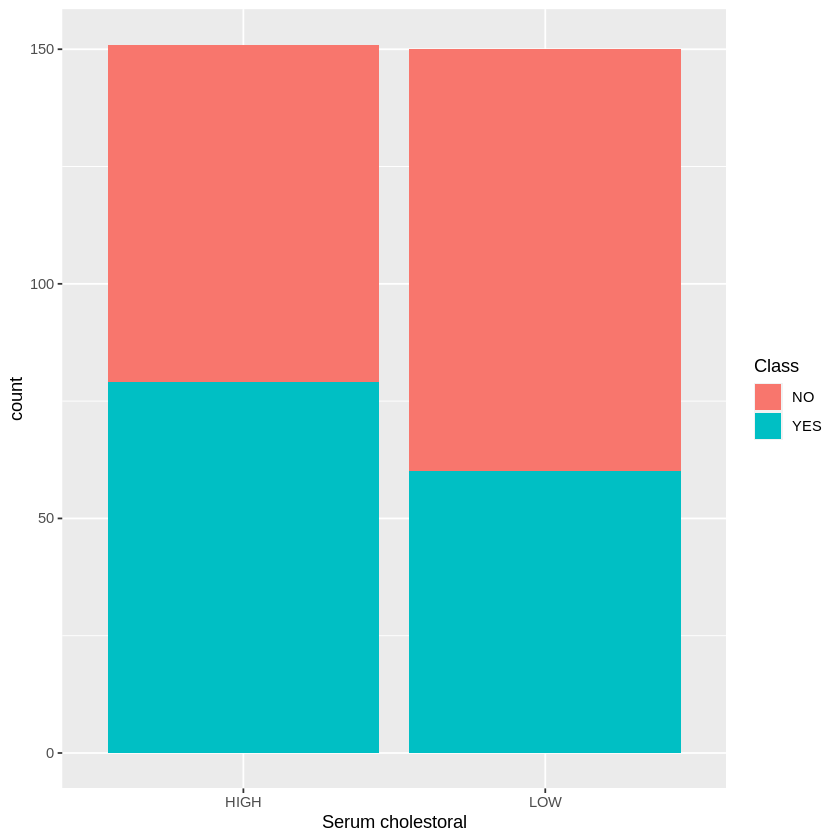

In [6]:
ggplot(heart_data, 
       aes(x = trestbps, fill = Class)) +
  geom_bar() + 
  labs(x = "Resting blood pressure of patients")

ggplot(heart_data, 
       aes(x = chol, fill = Class)) +
  geom_bar() + 
  labs(x = "Serum cholestoral")

## Compute estimates of the parameter

Below, we have created three data frame and two tables to summarize the data.The first data frame shows the proportion of the four combinations of low or high resting blood pressure and presence or absence of heart disease. The second data frame shows the proportion of the four combinations of the low or high cholesterol and the presence or absence of heart disease.The third and fourth table tells us the percentage of patients with high or low resting blood pressure and the percentage of patients with high or low cholesterol who have heart disease.The last data frame shows the estimates after taking 1000 replicates of "shuffles" and assuming the null hypothesis is true

In [27]:
#Generate the percentage of two variables under a four-column combination
heart_data_n <- heart_data %>%
                      tally()%>%
pull()

heart_data_prop_trestbps_0 <- 
    heart_data %>% 
    group_by(trestbps, Class)%>%
    count() %>% 
    mutate(p = n/heart_data_n)

heart_data_prop_chol_0 <- 
    heart_data %>% 
    group_by(chol, Class)%>%
    count() %>% 
    mutate(p = n/heart_data_n)

heart_data_prop_trestbps_0
heart_data_prop_chol_0

#Generate the proportion of patients with heart disease with or without high resting blood pressure
Trestbps <- c("HIGH","LOW")
Class <- c("YES","YES")
P <- c(81/(87+81),58/(75+58))
heart_data_prop_trestbps_1 <- data.frame(Trestbps,Class,P)
print(heart_data_prop_trestbps_1)
#Generate the proportion of patients with heart disease with or without high cholesterol
Chol <- c("HIGH","LOW")
P <- c(79/(79+72),60/(60+90))
heart_data_prop_chol_1 <- data.frame(Trestbps,Class,P)
print(heart_data_prop_chol_1)


#Generate estimates
null_distribution <- heart_data %>% 
  specify(formula = Class ~ trestbps, success = "YES") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("HIGH", "LOW"))

head(null_distribution)

trestbps,Class,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,87,0.2890365
HIGH,YES,81,0.2691030
LOW,NO,75,0.2491694
LOW,YES,58,0.1926910


chol,Class,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,72,0.2392027
HIGH,YES,79,0.2624585
LOW,NO,90,0.2990033
LOW,YES,60,0.1993355


  Trestbps Class         P
1     HIGH   YES 0.4821429
2      LOW   YES 0.4360902
  Trestbps Class         P
1     HIGH   YES 0.5231788
2      LOW   YES 0.4000000


replicate,stat
<int>,<dbl>
1,0.08646617
2,0.01911028
3,0.03258145
4,-0.02130326
5,-0.02130326
6,0.01911028


The differences in the proportion of having heart disease between LOW and HIGH, as reflected in the third and fourth tables, suggest that it would be possible to find out whether high or low resting blood pressure and high or low cholesterol make patients more likely to have heart disease.

## Methods

Given the number of observations in the dataset, we make sure that we have a sample that’s large enough. Also, our analysis process will strictly follow statistical rules and use scientific tools so that our result is unbiased and representative of the population.

The plots are not enough to give a stakeholder because the plots are generated using only a single sample. In other words, although we could obtain a point estimate from the sample, we cannot compute the sampling variation that quantifies the uncertainty about the point estimate. As a result, we cannot be confident enough that our point estimate from the single sample is close to the population parameter.


In order to address this gap, we will generate bootstrap samples based on our original sample, which is our dataset. Next, we will use the infer package in R to compute the sampling distribution of sample proportions. Furthermore, we will conduct a hypothesis test with null hypothesis… with a confidence interval level at 5%.

We expect to find that people with low blood pressure and low cholesterol level would have a lower chance of developing heart disease. Our findings could help raise awareness of the importance of keeping a healthy routine that keeps our blood pressure and cholesterol at a healthy level. Also, since our finding only studies the correlations of the explanatory and response variables, it would be worthy to find out the cause of heart diseases.


Although the distinction among the three classes is not very clear in the example plot above, the distinction between class 0 (no presence of heart disease) and 3/4 (presence of heart disease) is quite clear. By just comparing the two predictors used in the example, it would be a reasonable to predict that a person with low blood pressure (under 120mmHg) and a high max heart rate (over 150 BPM) will likely have some form of heart disease.

### Reference

[1] World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved July 26, 2022, from https://www.who.int/health-topics/cardiovascular-diseases </br>
[2] Centers for Disease Control and Prevention. (2020, April 21). Prevent heart disease. Centers for Disease Control and Prevention. Retrieved July 26, 2022, from https://www.cdc.gov/heartdisease/prevention.htm 